In [15]:
import pandas as pd
import sys
import os
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
sys.path.insert(0, '..')

%matplotlib inline

## Load Data, select relevant columns, average across play

In [5]:
all_passes = pd.read_pickle('../data/all_passes.pkl')
players = pd.read_csv('../data/players.csv')
player_stats = pd.read_pickle('../data/all_player_stats.pkl').merge(players[['nflId', 'position']], on='nflId')

display(player_stats)

,gameId,playId,frameId,frame_after_snap,nflId,displayName,team,team_pos,ind_eppa1,ind_eppa1_wo_value,position
0,2018090600,1037,25,14,2507763.0,Mike Wallace,PHI,OFF,0.466838,0.134048,WR
1,2018090600,1037,26,15,2507763.0,Mike Wallace,PHI,OFF,0.477848,0.134336,WR
2,2018090600,1037,27,16,2507763.0,Mike Wallace,PHI,OFF,0.469174,0.128070,WR
3,2018090600,1037,28,17,2507763.0,Mike Wallace,PHI,OFF,0.476088,0.125998,WR
4,2018090600,1037,29,18,2507763.0,Mike Wallace,PHI,OFF,0.449678,0.114301,WR
...,...,...,...,...,...,...,...,...,...,...,...
3140661,2018123015,640,35,24,2558095.0,Malachi Dupre,ARI,OFF,-0.116779,0.137603,WR
3140662,2018123015,640,36,25,2558095.0,Malachi Dupre,ARI,OFF,-0.122118,0.141135,WR
3140663,2018123015,640,37,26,2558095.0,Malachi Dupre,ARI,OFF,-0.119446,0.136201,WR
3140664,2018123015,640,38,27,2558095.0,Malachi Dupre,ARI,OFF,-0.124651,0.141001,WR


In [7]:
p_t = pd.read_csv('models/in/p_t.csv')
p_t = p_t.rename(columns={'frame_to_pass': 'frames_after_snap'})

# normalize p_t for each play
p_t_norm = p_t.merge(all_passes[['gameId', 'playId', 'frames_after_snap']], on='frames_after_snap')
p_t_norm['p_norm'] = p_t_norm['p'] / p_t_norm.groupby(['gameId', 'playId']).p.transform('sum')
#p_t_norm = p_t_norm[['gameId', 'playId', 'frames_after_snap', 'p', 'p_norm']]

In [8]:
# subset all_passes
all_passes_small = all_passes[['gameId', 'playId', 'frames_after_snap', 'off_team', 'def_team', 'eppa1_tot', 'max_eppa1_eppa1_xval']]
all_passes_small = p_t_norm.merge(all_passes_small, on=['gameId', 'playId', 'frames_after_snap'])

# assign probabilities to each pass based on p_t_merged
for f in ['max_eppa1_eppa1_xval', 'eppa1_tot']:
    all_passes_small[f+'_norm'] = all_passes_small[f] * all_passes_small['p_norm']

# group and agg
all_passes_grouped = all_passes_small.groupby(['gameId', 'playId'], as_index=False)
all_passes_final = all_passes_grouped.agg(eppa1_tot_frame_max=('eppa1_tot', 'max'), eppa1_tot_frame_mean=('eppa1_tot', 'mean'),
                max_eppa1_xval_frame_max=('max_eppa1_eppa1_xval', 'max'),  max_eppa1_xval_frame_mean=('max_eppa1_eppa1_xval', 'mean'),
                eppa1_tot_weight_sum=('eppa1_tot_norm', 'sum'), eppa1_tot_weight_max=('eppa1_tot_norm', 'max'),
                max_eppa1_weight_sum=('max_eppa1_eppa1_xval_norm', 'sum'), max_eppa1_weight_max=('max_eppa1_eppa1_xval_norm', 'max'),
                def_team=('def_team', 'min'), off_team=('off_team', 'min'))

In [9]:
# summarize each play by individual

# get player stats
player_stats_small = player_stats[['gameId', 'playId', 'nflId', 'displayName', 'frame_after_snap', 'team', 'ind_eppa1', 'ind_eppa1_wo_value', 'team_pos', 'position']].rename(columns={'frame_after_snap': 'frames_after_snap'})
player_stats_small = player_stats_small.merge(p_t_norm, on=['gameId', 'playId', 'frames_after_snap'])

# assign probabilities to each pass based on p_t_merged
for f in ['ind_eppa1_wo_value', 'ind_eppa1']:
    player_stats_small[f+'_norm'] = player_stats_small[f] * player_stats_small['p_norm']

# group and agg
player_stats_grouped = player_stats_small.groupby(['gameId', 'playId', 'nflId', 'position'], as_index=False)
player_stats_final = player_stats_grouped.agg(ind_eppa1_frame_max=('ind_eppa1', 'max'), ind_eppa1_frame_mean=('ind_eppa1', 'mean'),
                ind_eppa1_wo_value_frame_max=('ind_eppa1_wo_value', 'max'),  ind_eppa1_wo_value_frame_mean=('ind_eppa1_wo_value', 'mean'),
                ind_eppa1_weight_sum=('ind_eppa1_norm', 'sum'), ind_eppa1_weight_max=('ind_eppa1_norm', 'max'),
                ind_eppa1_wo_value_weight_sum=('ind_eppa1_wo_value_norm', 'sum'), ind_eppa1_wo_value_weight_max=('ind_eppa1_wo_value_norm', 'max'))
display(player_stats_final)

,gameId,playId,nflId,position,ind_eppa1_frame_max,ind_eppa1_frame_mean,ind_eppa1_wo_value_frame_max,ind_eppa1_wo_value_frame_mean,ind_eppa1_weight_sum,ind_eppa1_weight_max,ind_eppa1_wo_value_weight_sum,ind_eppa1_wo_value_weight_max
0,2018090600,75,79848.0,SS,0.130462,0.097512,0.064751,0.048584,0.103208,0.014314,0.050554,0.007104
1,2018090600,75,2495454.0,WR,0.316648,0.196858,0.171813,0.095128,0.174748,0.018573,0.082890,0.008798
2,2018090600,75,2495613.0,FS,0.099495,0.063417,0.059265,0.043175,0.067899,0.010917,0.045102,0.006503
3,2018090600,75,2533040.0,WR,0.179544,0.141505,0.074795,0.065199,0.150576,0.019700,0.067084,0.008124
4,2018090600,75,2534832.0,FS,0.163520,0.091946,0.051442,0.029403,0.105709,0.017990,0.033756,0.005660
...,...,...,...,...,...,...,...,...,...,...,...,...
213723,2018123015,4104,2552430.0,WR,0.564908,0.342599,0.187008,0.124490,0.342449,0.023777,0.126893,0.008542
213724,2018123015,4104,2553439.0,RB,0.149550,0.086122,0.158106,0.113472,0.075915,0.003473,0.104355,0.005257
213725,2018123015,4104,2557887.0,ILB,0.081226,0.060432,0.079293,0.059772,0.060220,0.003501,0.060202,0.003452
213726,2018123015,4104,2558009.0,FS,0.103563,0.023483,0.088283,0.046280,0.032646,0.005477,0.051163,0.004656


## Defensive Rankings

In [10]:
# groupby defense
agg = 'max_eppa1_xval_frame_mean'
display(all_passes_final)
team_rankings_def = all_passes_final.groupby('def_team')[agg].mean().sort_values(ascending=True).to_frame()
#team_rankings_def[agg] = team_rankings_def[agg] - team_rankings_def[agg].min()
#team_rankings_def['voa'] = 100 * (team_rankings_def.mean() - team_rankings_def) / team_rankings_def.mean()
display(team_rankings_def.reset_index())

,gameId,playId,eppa1_tot_frame_max,eppa1_tot_frame_mean,max_eppa1_xval_frame_max,max_eppa1_xval_frame_mean,eppa1_tot_weight_sum,eppa1_tot_weight_max,max_eppa1_weight_sum,max_eppa1_weight_max,def_team,off_team
0,2018090600,75,0.304227,0.155386,1.994059,1.517320,0.180171,0.033471,1.505527,0.218787,PHI,ATL
1,2018090600,146,-0.008296,-0.032475,1.140115,0.963365,-0.035303,-0.001014,0.960285,0.189423,PHI,ATL
2,2018090600,168,0.063349,-0.168358,1.694329,1.448525,-0.134169,0.008823,1.492751,0.235986,PHI,ATL
3,2018090600,190,-0.408416,-0.565080,2.632227,2.423302,-0.558615,-0.014296,2.443968,0.217192,PHI,ATL
4,2018090600,256,-0.543809,-0.597149,0.925808,0.835314,-0.589715,-0.049597,0.822472,0.156349,PHI,ATL
...,...,...,...,...,...,...,...,...,...,...,...,...
16855,2018123015,3794,-0.044463,-0.105637,0.930404,0.635187,-0.094089,-0.004878,0.655265,0.101111,SEA,ARI
16856,2018123015,3819,0.052481,-0.023104,1.556246,1.174187,-0.031171,0.002403,1.190142,0.099327,SEA,ARI
16857,2018123015,3969,-0.387237,-0.458799,1.958739,1.606703,-0.458942,-0.010238,1.562569,0.105699,SEA,ARI
16858,2018123015,4057,0.073753,0.018866,1.563665,1.191530,0.012741,0.003216,1.246211,0.152309,ARI,SEA


,def_team,max_eppa1_xval_frame_mean
0,DET,1.294977
1,NE,1.304903
2,TEN,1.333824
3,KC,1.345618
4,DEN,1.351604
5,NO,1.354903
6,SEA,1.357119
7,GB,1.361873
8,CIN,1.364899
9,CLE,1.368197


## Position Rankings

In [127]:
#agg = 'ind_eppa1'
#display(player_stats_final.loc[player_stats_final.team_pos == 'DEF'])
#position_stats_final = player_stats_final.loc[player_stats_final.team_pos == 'DEF'].merge(players[['nflId', 'position']])
#pos_rankings = position_stats_final.groupby('position')[agg].mean().sort_values(ascending=True).to_frame()

##pos_rankings
np.random.seed(0)

## Player Rankings within Position Groups

In [74]:
col1 = 'ind_eppa1_weight_sum'
col2 = 'ind_eppa1_wo_value_weight_sum'
player_stats_final['count'] = player_stats_final.groupby(['nflId', 'position'], as_index=False).nflId.transform('count')
player_stats_merged = player_stats_final.merge(players[['nflId', 'displayName']], on='nflId')#[['nflId', 'position', 'displayName', agg, 'count']]
#display(player_stats_merged)

ind_pos_rankings = player_stats_merged.groupby(['nflId', 'position', 'displayName']).agg(col1=(col1, 'mean'), cnt=('count', 'max'), col2=(col2, 'mean'))
#display(ind_pos_rankings)
players_with_eppa = ind_pos_rankings.merge(players, on='nflId')[['nflId', 'position', 'displayName', 'col1', 'col2', 'cnt']]

mapping = {'DB': 'DB', 'CB': 'DB', 'S': 'S', 'SS': 'S', 'FS': 'S', 'WR': 'WR', 'MLB': 'LB', 'OLB': 'LB',
               'ILB': 'LB', 'LB': 'LB', 'DL': 'DL', 'DT': 'DL', 'DE': 'DL', 'NT': 'DL', 'QB': 'QB', 'RB': 'RB',
               'HB': 'RB', 'TE': 'TE', 'P': 'ST', 'K': 'ST', 'LS': 'ST', 'FB': 'FB'}
print(players_with_eppa.groupby('position').count())
players_with_eppa['position'] = players_with_eppa.position.map(mapping)

#players_with_eppa.loc[(players_with_eppa.position == 'WR') & (players_with_eppa.cnt >= 300)].sort_values('col2', ascending=False).head(20)

          nflId  displayName  col1  col2  cnt
position                                     
CB          193          193   193   193  193
DB           32           32    32    32   32
DE           35           35    35    35   35
DT            3            3     3     3    3
FB           19           19    19    19   19
FS           64           64    64    64   64
HB            5            5     5     5    5
ILB          55           55    55    55   55
LB           55           55    55    55   55
LS            1            1     1     1    1
MLB          28           28    28    28   28
NT            1            1     1     1    1
OLB          96           96    96    96   96
P             1            1     1     1    1
RB          132          132   132   132  132
S            11           11    11    11   11
SS           58           58    58    58   58
TE          128          128   128   128  128
WR          228          228   228   228  228


In [135]:
import seaborn as sns

#players_with_eppa.loc[(players_with_eppa.cnt >= 300)].sort_values('col1', ascending=False).head(10).position.unique()
players_with_eppa = players_with_eppa.loc[(players_with_eppa.cnt >= 300) & (players_with_eppa.position.isin(['DB', 'LB', 'S']))]#.sort_values('col1', ascending=False).head(150).tail(20)
ids = np.arange(players_with_eppa.shape[0])
np.random.shuffle(ids)

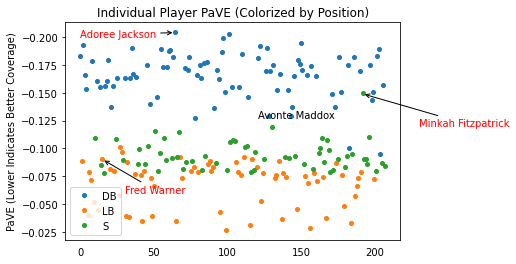

In [155]:
players_with_eppa['id'] = ids
# plot each player's eppa and color by position

groups = players_with_eppa.groupby('position')
fig, ax = plt.subplots()
#ax.set_prop_cycle()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.id, group.col1 * -1, marker='o', linestyle='', ms=4, label=name)
ax.legend(numpoints=1, loc='lower left')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
ax.set_title('Individual Player PaVE (Colorized by Position)')
ax.set_ylabel('PaVE (Lower Indicates Better Coverage)')
plt.gca().invert_yaxis()
ax.annotate('Minkah Fitzpatrick', (192, -0.149), xytext=(230, -0.12), arrowprops={'arrowstyle':'->'}, color='red')
ax.annotate('Fred Warner', (15, -0.09), xytext=(30, -0.06), arrowprops={'arrowstyle':'->'}, color='red')
ax.annotate('Adoree Jackson', (64, -0.204), xytext=(0, -0.2), arrowprops={'arrowstyle':'->'}, color='red')
ax.annotate('Avonte Maddox', (121, -0.127))
plt.show()

In [147]:
players_with_eppa.loc[(players_with_eppa.position == 'LB') & (players_with_eppa.cnt >= 200)].sort_values('col1', ascending=False).head(20)

,nflId,position,displayName,col1,col2,cnt,id
670,2556148.0,LB,Jatavis Brown,0.101320,0.045808,335,27
1014,2560877.0,LB,Roquan Smith,0.096452,0.046918,504,28
817,2558094.0,LB,Zach Cunningham,0.092617,0.044377,380,68
986,2560789.0,LB,Darius Leonard,0.091831,0.040930,460,111
1035,2560917.0,LB,Fred Warner,0.090481,0.042320,488,15
1056,2560966.0,LB,Jerome Baker,0.090082,0.046654,318,117
257,2539935.0,LB,Kiko Alonso,0.088774,0.042929,462,88
597,2555255.0,LB,De'Vondre Campbell,0.088695,0.043181,476,135
874,2558851.0,LB,Anthony Walker,0.088541,0.042438,303,1
450,2552312.0,LB,Eric Kendricks,0.087777,0.045947,373,32


In [28]:
players_with_eppa.loc[(players_with_eppa.cnt >= 300)].groupby('position').col1.mean().sort_values(ascending=False)

position
WR    0.183378
DB    0.166028
TE    0.162772
RB    0.116328
S     0.096327
FS    0.092495
LB    0.068368
DL    0.030356
Name: col1, dtype: float64

In [45]:
# load coverages
cov = pd.read_csv('data/coverages_week1.csv')

cov_rankings = cov.merge(all_passes_final, on=['gameId', 'playId'])
cov_rankings['count'] = cov_rankings.groupby('coverage').gameId.transform('count')
cov_rankings_grouped = cov_rankings.groupby('coverage').mean().sort_values('eppa1_tot_weight_sum')


In [47]:
cov_rankings_grouped.sort_values('eppa1_tot_frame_mean')

,gameId,playId,eppa1_tot_frame_max,eppa1_tot_frame_mean,max_eppa1_xval_frame_max,max_eppa1_xval_frame_mean,eppa1_tot_weight_sum,eppa1_tot_weight_max,max_eppa1_weight_sum,max_eppa1_weight_max,count
coverage,,,,,,,,,,,
Cover 0 Man,2.018091e+09,2362.500000,-0.084264,-0.229617,1.956735,1.733618,-0.231960,0.005788,1.734950,0.355023,12.0
Cover 1 Man,2.018091e+09,2078.552124,-0.090088,-0.197876,1.610387,1.242018,-0.195827,-0.008729,1.248862,0.189063,259.0
Cover 2 Man,2.018091e+09,2692.555556,-0.039913,-0.181000,1.558532,1.033538,-0.191241,-0.004176,1.007052,0.122716,27.0
Cover 3 Zone,2.018091e+09,2277.573248,0.134146,0.011858,1.855694,1.477737,0.018686,0.007317,1.499335,0.221813,314.0
Cover 6 Zone,2.018091e+09,2158.700000,0.238382,0.081132,1.996329,1.544236,0.090483,0.014534,1.583139,0.223415,60.0
Cover 4 Zone,2.018091e+09,2289.814286,0.219310,0.099258,1.932048,1.564833,0.102326,0.023549,1.577656,0.216257,140.0
Cover 2 Zone,2.018091e+09,2306.247525,0.269400,0.126353,1.965571,1.540768,0.144630,0.024836,1.567105,0.216076,101.0
Prevent Zone,2.018091e+09,4464.000000,1.868332,1.445551,3.334682,2.854121,1.351673,0.069598,2.811861,0.158662,1.0
